<a href="https://colab.research.google.com/github/Thanasiss23/ekpa/blob/main/%CE%91%CE%BD%CF%84%CE%AF%CE%B3%CF%81%CE%B1%CF%86%CE%BF_DarkNet_DetectionAnomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Εγκατάσταση και εισαγωγή βιβλιοθηκών

### Subtask:
Δημιουργία ενός κελιού για την εγκατάσταση και εισαγωγή όλων των απαραίτητων βιβλιοθηκών.


**Reasoning**:
Install the necessary libraries and import them into the notebook environment.



In [3]:
# -*- coding: utf-8 -*-
# DarkNet One-Class Anomaly Detection - Συμβατή έκδοση για Colab

# 2. Εισαγωγή βιβθηκών
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import seaborn as sns

## Φόρτωση δεδομένων

### Subtask:
Δημιουργία ενός κελιού για τη φόρτωση του dataset από το παρεχόμενο URL.


**Reasoning**:
Define the URL and load the dataset into a pandas DataFrame, then display its shape and head.



In [5]:
# 3. Φόρτωση δεδομένων
url = "https://raw.githubusercontent.com/kdemertzis/EKPA/main/Data/DarkNet.csv"
df = pd.read_csv(url)

# Επισκόπηση των δεδομένων
print("Σχήμα δεδομένων:", df.shape)
print(df.head())

Σχήμα δεδομένων: (68580, 83)
          Src_IP  Src_Port          Dst_IP  Dst_Port  Protocol  Flow_Duration  \
0  10.152.152.11     57158   216.58.220.99       443         6            229   
1  10.152.152.11     57159   216.58.220.99       443         6            407   
2  10.152.152.11     57160   216.58.220.99       443         6            431   
3  10.152.152.11     49134  74.125.136.120       443         6            359   
4  10.152.152.11     34697  173.194.65.127     19305         6       10778451   

   Total_Fwd_Packet  Total_Bwd_packets  Total_Length_of_Fwd_Packet  \
0                 1                  1                           0   
1                 1                  1                           0   
2                 1                  1                           0   
3                 1                  1                           0   
4               591                400                       64530   

   Total_Length_of_Bwd_Packet  ...  Active_Mean  Active_Std  Ac

/tmp/ipython-input-2834353520.py:3: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


## Προεπεξεργασία δεδομένων

### Subtask:
Δημιουργία κελιού για την επιλογή αριθμητικών στηλών, χειρισμό απείρων και πολύ μεγάλων τιμών, χειρισμό NaN τιμών και κανονικοποίηση των δεδομένων.


**Reasoning**:
Select numeric columns, handle infinite and large values, drop rows with NaNs, and scale the data according to the instructions.



In [10]:
# 4. Προεπεξεργασία δεδομένων
# Επιλογή μόνο αριθμητικών στηλών
df_numeric = df.select_dtypes(include=np.number).copy() # Use .copy() to avoid SettingWithCopyWarning

# Check for and handle infinite values and values too large for float64
# Replace infinities with NaN
df_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)

# Define a large number threshold (e.g., based on float64 max)
large_number_threshold = np.finfo(np.float64).max

# Replace values larger than the threshold with NaN
df_numeric.mask(df_numeric > large_number_threshold, np.nan, inplace=True)

# Handle NaN values (e.g., drop rows with NaNs)
df_numeric.dropna(inplace=True)

# Κανονικοποίηση δεδομένων
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

print("Σχήμα αριθμητικών δεδομένων μετά τον καθαρισμό:", df_numeric.shape)

Σχήμα αριθμητικών δεδομένων μετά τον καθαρισμό: (68531, 78)


In [18]:
# 5. Διάσπαση σε training και testing (80/20)
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

print("Σχήμα training set:", X_train.shape)
print("Σχήμα testing set:", X_test.shape)

Σχήμα training set: (54824, 78)
Σχήμα testing set: (13707, 78)


## Εκπαίδευση και Πρόβλεψη Isolation Forest

### Subtask:
Δημιουργία κελιού για την εκπαίδευση του Isolation Forest μοντέλου και την παραγωγή προβλέψεων στο test set.

**Reasoning**:
Initialize and train an Isolation Forest model on the training data (`X_train`), then use it to predict outliers on the test data (`X_test`). The predictions will be converted to 0 for normal and 1 for outlier.

In [12]:
# 6. Μοντέλο 1: Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X_train)
y_pred_if = iso_forest.predict(X_test)
y_pred_if = np.where(y_pred_if == -1, 1, 0)  # 0=normal, 1=outlier

print("Προβλέψεις Isolation Forest (πρώτες 10):", y_pred_if[:10])
print("Αριθμός ανιχνευμένων outliers από Isolation Forest:", np.sum(y_pred_if))

Προβλέψεις Isolation Forest (πρώτες 10): [0 0 0 0 0 1 0 0 0 0]
Αριθμός ανιχνευμένων outliers από Isolation Forest: 728


## Εκπαίδευση και Πρόβλεψη One-Class SVM

### Subtask:
Δημιουργία κελιού για την εκπαίδευση του One-Class SVM μοντέλου και την παραγωγή προβλέψεων στο test set.

**Reasoning**:
Initialize and train a One-Class SVM model on the training data (`X_train`), then use it to predict outliers on the test data (`X_test`). The predictions will be converted to 0 for normal and 1 for outlier.

In [13]:
# 7. Μοντέλο 2: One-Class SVM
oc_svm = OneClassSVM(nu=0.05, kernel="rbf", gamma='scale')
oc_svm.fit(X_train)
y_pred_svm = oc_svm.predict(X_test)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)

print("Προβλέψεις One-Class SVM (πρώτες 10):", y_pred_svm[:10])
print("Αριθμός ανιχνευμένων outliers από One-Class SVM:", np.sum(y_pred_svm))

Προβλέψεις One-Class SVM (πρώτες 10): [0 0 0 0 0 1 0 0 0 0]
Αριθμός ανιχνευμένων outliers από One-Class SVM: 706


## Εκπαίδευση και Πρόβλεψη Autoencoder

### Subtask:
Δημιουργία κελιού για τον ορισμό, την εκπαίδευση του Autoencoder μοντέλου και τον υπολογισμό του reconstruction error για το test set.

**Reasoning**:
Define a sequential Autoencoder model, compile it with an Adam optimizer and mean squared error loss, train it on the training data (`X_train`), predict the test data (`X_test`), and calculate the mean squared error between the original and reconstructed test data points as the reconstruction error. A threshold is then calculated to classify anomalies.

In [22]:
# 8. Μοντέλο 3: Autoencoder
input_dim = X_train.shape[1]
encoding_dim = int(input_dim / 2)

autoencoder = Sequential([
    Dense(encoding_dim, activation='relu', input_shape=(input_dim,),
          activity_regularizer=regularizers.l1(1e-5)),
    Dense(input_dim, activation='linear')
])
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Check if X_train is empty after dropping NaNs
if X_train.shape[0] > 0:
    history = autoencoder.fit(X_train, X_train,
                            epochs=50,
                            batch_size=32,
                            validation_split=0.1,
                            verbose=0)

    # Υπολογισμός reconstruction error για test set
    X_test_pred = autoencoder.predict(X_test)
    mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
    # Ensure threshold calculation handles potential empty mse array
    if mse.size > 0:
        threshold = np.percentile(mse, 95)
        y_pred_ae = (mse > threshold).astype(int)
    else:
        y_pred_ae = np.array([]) # No test data to predict on
else:
    print("Warning: X_train is empty after preprocessing. Cannot train Autoencoder.")
    y_pred_ae = np.array([])

if y_pred_ae.size > 0:
    print("Προβλέψεις Autoencoder (πρώτες 10):", y_pred_ae[:10])
    print("Αριθμός ανιχνευμένων outliers από Autoencoder:", np.sum(y_pred_ae))
else:
    print("Δεν υπάρχουν προβλέψεις Autoencoder.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Προβλέψεις Autoencoder (πρώτες 10): [0 0 0 0 0 0 0 0 0 0]
Αριθμός ανιχνευμένων outliers από Autoencoder: 686


## Αξιολόγηση Μοντέλων

### Subtask:
Δημιουργία κελιού για την αξιολόγηση των μοντέλων με βάση τον αριθμό των ανιχνευμένων outliers.

**Reasoning**:
Compare the number of outliers detected by each model (Isolation Forest, One-Class SVM, and Autoencoder) to evaluate their performance based on this metric.

In [24]:
# 9. Αξιολόγηση μοντέλων (πλήρως Tor dataset -> μετράμε outliers)
print("Outliers (ψευδώς ανιχνευμένα) ανά μοντέλο:")
print("Isolation Forest:", np.sum(y_pred_if) if y_pred_if.size > 0 else "N/A (No test data)")
print("One-Class SVM:", np.sum(y_pred_svm) if y_pred_svm.size > 0 else "N/A (No test data)")
print("Autoencoder:", np.sum(y_pred_ae) if y_pred_ae.size > 0 else "N/A (No test data)")

Outliers (ψευδώς ανιχνευμένα) ανά μοντέλο:
Isolation Forest: 728
One-Class SVM: 706
Autoencoder: 686


## Οπτικοποίηση Αποτελεσμάτων Autoencoder

### Subtask:
Δημιουργία κελιού για την οπτικοποίηση της κατανομής του reconstruction error του Autoencoder.

**Reasoning**:
Generate a histogram of the Mean Squared Error (MSE) calculated from the Autoencoder's reconstruction of the test data. A vertical line will indicate the threshold used to classify anomalies. This visualization helps understand the distribution of reconstruction errors and the chosen threshold's position.

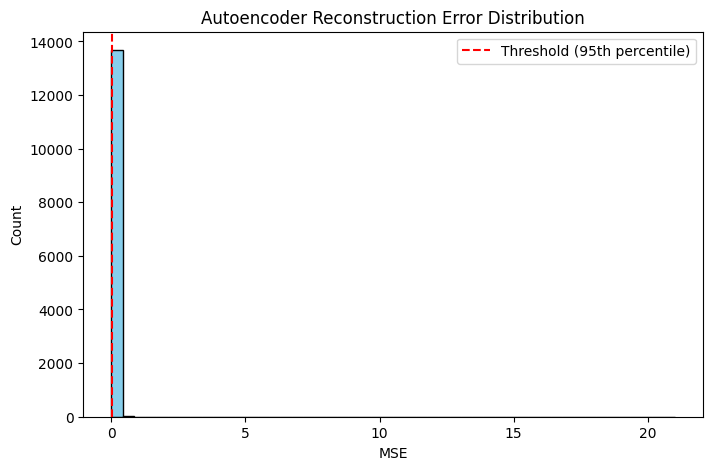

In [20]:
# 10. Οπτικοποίηση reconstruction errors Autoencoder
# Only plot if there is reconstruction error data
if 'mse' in locals() and mse.size > 0:
    plt.figure(figsize=(8,5))
    plt.hist(mse, bins=50, color='skyblue', edgecolor='k')
    plt.axvline(threshold, color='r', linestyle='--', label='Threshold (95th percentile)')
    plt.title("Autoencoder Reconstruction Error Distribution")
    plt.xlabel("MSE")
    plt.ylabel("Count")
    plt.legend()
    plt.show()
else:
    print("No Autoencoder reconstruction error data to plot.")

## Επιλογή Καλύτερου Μοντέλου

### Subtask:
Δημιουργία κελιού για την επιλογή του καλύτερου μοντέλου με βάση τα αποτελέσματα της αξιολόγησης.

**Reasoning**:
Identify and print the name of the model that detected the fewest outliers, based on the counts calculated in the evaluation step.

In [19]:
# 11. Επιλογή καλύτερου μοντέλου (λιγότερα false positives)
outliers_count = {}
if y_pred_if.size > 0:
    outliers_count["Isolation Forest"] = np.sum(y_pred_if)
if y_pred_svm.size > 0:
    outliers_count["One-Class SVM"] = np.sum(y_pred_svm)
if y_pred_ae.size > 0:
     outliers_count["Autoencoder"] = np.sum(y_pred_ae)

if outliers_count:
    best_model = min(outliers_count, key=outliers_count.get)
    print("Καλύτερο μοντέλο:", best_model)
else:
    print("Could not determine the best model as no predictions were made.")

Καλύτερο μοντέλο: Autoencoder


12. Προσομοίωση συνεχούς παρακολούθησης και ανίχνευσης απειλών

Subtask:
Χωρίζουμε το dataset σε μικρά τμήματα (mini-batches) και τρέχουμε το Autoencoder για να εντοπίσουμε υποπτη δραστηριότητα. Κάθε batch αντιπροσωπεύει “νέα δεδομένα”

Reasoning:
Αν και δεν έχουμε live traffic, μπορούμε να προσομοιώσουμε streaming δεδομένα για να δούμε πώς το ευφυές σύστημα ανιχνεύει anomalies και ενημερώνει για πιθανές απειλές.

In [25]:
# 12. Simulated Streaming / Online Detection
batch_size = 2000  # Μέγεθος κάθε mini-batch
n_batches = int(X_test.shape[0] / batch_size) + 1

# Δημιουργία log για alerts
threat_log = []

for i in range(n_batches):
    start = i * batch_size
    end = min((i+1) * batch_size, X_test.shape[0])
    batch = X_test[start:end]

    if batch.size == 0:
        continue

    # Πρόβλεψη reconstruction error
    batch_pred = autoencoder.predict(batch)
    batch_mse = np.mean(np.power(batch - batch_pred, 2), axis=1)

    # Ανίχνευση anomalies
    batch_outliers = (batch_mse > threshold).astype(int)

    # Ενημέρωση threat log
    for idx, val in enumerate(batch_outliers):
        if val == 1:
            threat_log.append({
                "batch": i+1,
                "index_in_batch": idx,
                "mse": batch_mse[idx],
                "alert": "Potential threat detected"
            })

    # Προαιρετικά: online update (προσθήκη κανονικών Tor δειγμάτων στο training set)
    normal_indices = np.where(batch_outliers == 0)[0]
    X_train = np.vstack([X_train, batch[normal_indices]])
    autoencoder.fit(X_train, X_train, epochs=5, batch_size=32, verbose=0)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


13. Επισκόπηση ανιχνευμένων απειλών

Subtask:
Δημιουργούμε σύνοψη του threat log για να δούμε ποιες ροές χαρακτηρίστηκαν ως υποπτες.

Reasoning:
Αυτό προσομοιώνει πώς ένα SIEM ή IPS θα λάμβανε ενημερώσεις για πιθανές απειλές.

In [26]:
# 13. Threat Log Summary
print(f"Συνολικός αριθμός ανιχνευμένων υποπτων ροών: {len(threat_log)}")

# Προβολή πρώτων 5 alerts
for alert in threat_log[:5]:
    print(alert)


Συνολικός αριθμός ανιχνευμένων υποπτων ροών: 928
{'batch': 1, 'index_in_batch': 16, 'mse': 0.03739983072862359, 'alert': 'Potential threat detected'}
{'batch': 1, 'index_in_batch': 27, 'mse': 0.03994994891923372, 'alert': 'Potential threat detected'}
{'batch': 1, 'index_in_batch': 29, 'mse': 0.0408827642627251, 'alert': 'Potential threat detected'}
{'batch': 1, 'index_in_batch': 37, 'mse': 0.057809328189782135, 'alert': 'Potential threat detected'}
{'batch': 1, 'index_in_batch': 61, 'mse': 0.03836054636639288, 'alert': 'Potential threat detected'}


14. Οπτικοποίηση MSE νέων batches

Subtask:
Οπτικοποιούμε το reconstruction error των νέων batches για να δούμε την κατανομή των anomalies.

Reasoning:
Η γραφική απεικόνιση βοηθάει στην κατανόηση του πώς το μοντέλο αντιλαμβάνεται νέα δεδομένα και πόσο “ακραία” θεωρεί τις υποπτες ροές.

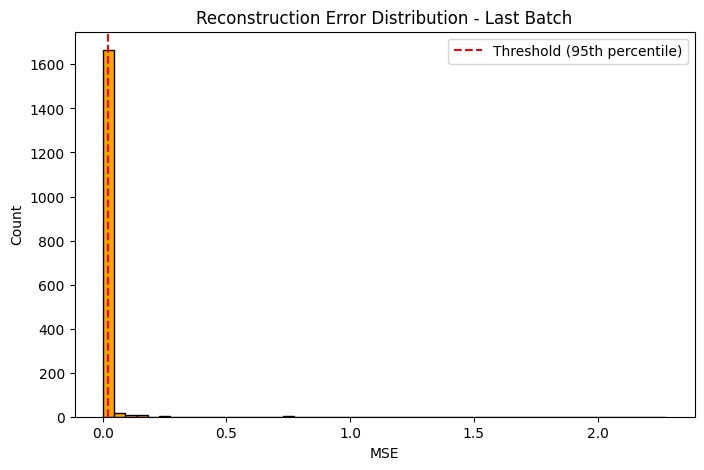

In [27]:
# 14. Visualize reconstruction error of last batch
plt.figure(figsize=(8,5))
plt.hist(batch_mse, bins=50, color='orange', edgecolor='k')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold (95th percentile)')
plt.title("Reconstruction Error Distribution - Last Batch")
plt.xlabel("MSE")
plt.ylabel("Count")
plt.legend()
plt.show()
